### Imports

In [1]:
import pandas as pd
import numpy as np
import random as random
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pickle as pkl
import networkx as nx


from tqdm.notebook import tqdm

### Helper Functions

In [2]:
def sub_len(L):
    '''
    Returns length of sub-lists
    '''
    return [len(l) for l in L]

In [3]:
def create_interaction_dicts(interactions):

    drug_dict = {}
    target_dict = {}

    for i in tqdm(range(len(interactions))):

        drug_id = interactions['InChiKey'].values[i]
        target_id = interactions['target_aa_code'].values[i]
        binding = interactions['Y'].values[i]

        try:
            drug_dict[drug_id]
        except:
            drug_dict[drug_id] = {}

        try:
            drug_dict[drug_id][binding].append(target_id)
        except:
            drug_dict[drug_id][binding] = [target_id]

        try:
            target_dict[target_id]
        except:
            target_dict[target_id] = {}

        try:
            target_dict[target_id][binding].append(drug_id)
        except:
            target_dict[target_id][binding] = [drug_id]

    return drug_dict, target_dict

In [4]:
def create_adjacency(drug_dict, target_dict, full = True, include_negative = False):
    
    # Create Adjascency Matrix For Drugs x Amino Acids
    drug_list = list(drug_dict.keys())
    target_list = list(target_dict.keys())
    number_of_drugs = len(list(drug_dict.keys()))
    number_of_targets = len(list(target_dict.keys()))

    adjascency_matrix = np.zeros((number_of_drugs, number_of_targets))

    if include_negative == False: 
        for i in tqdm(range(number_of_drugs)):
            for j in range(number_of_targets):

                try:
                    if target_list[j] in drug_dict[drug_list[i]][1]:
                        adjascency_matrix[i][j] = 1
                except: 
                    None

                try: 
                    if target_list[j] in drug_dict[drug_list[i]][0]:
                        adjascency_matrix[i][j] = 0
                except: 
                    None
                    
    else : 
        for i in tqdm(range(number_of_drugs)):
            for j in range(number_of_targets):

                try:
                    if target_list[j] in drug_dict[drug_list[i]][1]:
                        adjascency_matrix[i][j] = 1
                except: 
                    None

                try: 
                    if target_list[j] in drug_dict[drug_list[i]][0]:
                        adjascency_matrix[i][j] = -1
                except: 
                    None
                
    if full == False: 
        return adjascency_matrix
    
    else: 
        true_adjacency_matrix_bipartite = np.block([
            [np.zeros((len(drug_dict), len(drug_dict))), adjascency_matrix],
            [adjascency_matrix.T, np.zeros((len(target_dict), len(target_dict)))]
        ])
        return true_adjacency_matrix_bipartite

In [5]:
def get_eigen(adjacency):
    
    start_time = time.time()
    eigen_values, eigen_vectors = np.linalg.eig(adjacency)
    end_time = time.time()
    print ("Time Taken : ", end_time - start_time, "s")
    eigen_values_sorted = np.sort(eigen_values)
    
    return eigen_values, eigen_vectors, eigen_values_sorted

### Static Data Files

In [6]:
# Read In Drugs

drugs = pd.read_csv('/data/sars-busters/chemicals/chemicals_01.csv')
max_drug_length = max([len(str(x)) for x in drugs['fingerprint'].values])

In [7]:
# Read In Targets

targets = pd.read_csv('/data/sars-busters/amino/amino_01.csv')
max_target_length = max([len(x) for x in targets['Label'].values])

In [8]:
# Read In The Network

positive_interactions = pd.read_csv('/data/sars-busters-consolidated/interactions/dataset_1.csv')

### Create 13 Hop Negatives

In [9]:
# Create Drug and Target Dictionaries
drug_dict, target_dict = create_interaction_dicts(positive_interactions)

# Create Adjacency Matrix For The Netwokr From Above Dictionaries
adjacency = create_adjacency(drug_dict, target_dict)

# Create A List Of Degrees
degree = np.sum(adjacency, axis = 0) + 1e-2

  0%|          | 0/30813 [00:00<?, ?it/s]

  0%|          | 0/8111 [00:00<?, ?it/s]

In [10]:
components = nx.connected_components(nx.Graph(adjacency))
components = list(components)
print ("Number Of Components : ", len(components))

component_sizes = [len(list(components[i])) for i in range(len(components))]

Number Of Components :  387


In [11]:
adjacency.shape

(13215, 13215)

In [13]:
print('Size of LCC: ', max(component_sizes))

Size of LCC:  12079


In [14]:
num_nodes = adjacency.shape[0]
max_hop = 13
higher_adjacency_matrix = np.zeros((num_nodes, num_nodes, max_hop + 1))

higher_adjacency_matrix[:,:,0] =  np.identity(num_nodes)

for i in tqdm(range(1, max_hop)):
    higher_adjacency_matrix[:, :, i] = np.dot(higher_adjacency_matrix[:, :, i - 1], adjacency)
    
higher_adjacency_matrix[:, :, max_hop] = np.ones((num_nodes, num_nodes))

  0%|          | 0/12 [00:00<?, ?it/s]

In [15]:
# Check At Higher Hops

num_nodes = adjacency.shape[0]
max_hop = 16
higher_adjacency_matrix_two =  np.zeros((num_nodes, num_nodes, max_hop + 1))

higher_adjacency_matrix_two[:,:,0:13] =  higher_adjacency_matrix[:,:,0:13]

for i in tqdm(range(13, max_hop)):
    higher_adjacency_matrix_two[:, :, i] = np.dot(higher_adjacency_matrix_two[:, :, i - 1], adjacency)
    
higher_adjacency_matrix_two[:, :, max_hop] = np.ones((num_nodes, num_nodes))

  0%|          | 0/3 [00:00<?, ?it/s]

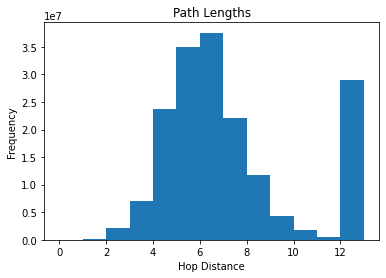

In [14]:
path_length = (higher_adjacency_matrix != 0).argmax(axis = 2)
plt.title("Path Lengths")
plt.xlabel("Hop Distance")
plt.ylabel("Frequency")
plt.hist(path_length.flatten(),bins=list(range(0,14)))
plt.show()

(array([1.3215000e+04, 6.1626000e+04, 2.0999140e+06, 7.0041720e+06,
        2.3725466e+07, 3.4878148e+07, 3.7552114e+07, 2.2173892e+07,
        1.1758018e+07, 4.2354100e+06, 1.7068620e+06, 4.8288600e+05,
        1.6989600e+05, 3.3846000e+04, 1.0022000e+04, 2.8730738e+07]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 16 Patch objects>)

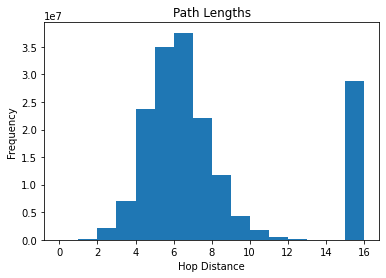

In [112]:
path_length = (higher_adjacency_matrix_two != 0).argmax(axis = 2)
plt.title("Path Lengths")
plt.xlabel("Hop Distance")
plt.ylabel("Frequency")
plt.hist(path_length.flatten(),bins = list(range(0, 17)))
# plt.show()

In [147]:
drug_split = len(drug_dict)
target_split = len(target_dict)
drug_list = list(drug_dict)
target_list = list(target_dict)

# Create 13 - Hop Negatives
dataframe = []
for i, j in tqdm(zip(*np.where((path_length >= 10) & (path_length < 16)))):
    if i < drug_split and j >= drug_split:
        dataframe.append([drug_list[i], target_list[j - drug_split], 0])
        
negatives = pd.DataFrame(dataframe)
negatives.columns = ["InChiKey", "target_aa_code", "Y"]

In [150]:
negatives

,InChiKey,target_aa_code,Y
0,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MKKLAIMAAASMVFAVSSAHAGFTPSGTTGTTKLTVTEECQVRVGD...,0
1,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MESPSAPPHRWCIPWQRLLLTASLLTFWNPPTTAKLTIESTPFNVA...,0
2,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MRMKRFLTIVQILLVVIIIIFGYKIVQTYIEDKQERANYEKLQQKF...,0
3,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MSPAPVQVMGVLNVTDDSFSDGGCYLDLDDAVKHGLAMAAAGAGIV...,0
4,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MSEISRQEFQRRRQALVEQMQPGSAALIFAAPEVTRSADSEYPYRQ...,0
...,...,...,...
259168,DAUMHRNXYGHXIC-UHFFFAOYSA-N,MSEISRQEFQRRRQALVEQMQPGSAALIFAAPEVTRSADSEYPYRQ...,0
259169,DAUMHRNXYGHXIC-UHFFFAOYSA-N,MNPNQKIITIGSVSLTIATVCFLMQIAILVTTVTLHFKQHECDSPA...,0
259170,DAUMHRNXYGHXIC-UHFFFAOYSA-N,MNMKKLATLVSAVALSATVSANAMAKDTIALVVSTLNNPFFVSLKD...,0
259171,DAUMHRNXYGHXIC-UHFFFAOYSA-N,MSDFDTERVSRAVAAALVGPGGVALVVKVFAGLPGVIHTPARRGFF...,0


In [151]:
negatives.to_csv('/data/sars-busters-consolidated/interactions/13_hop_negatives_DS1.csv', index = False) ## should be DS2 

In [6]:
negatives_13_hops = pd.read_csv('/data/sars-busters-consolidated/interactions/13_hop_negatives_DS1.csv') ## this is not actually 

In [155]:
negatives_13_hops

,InChiKey,target_aa_code,Y
0,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MKKLAIMAAASMVFAVSSAHAGFTPSGTTGTTKLTVTEECQVRVGD...,0
1,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MESPSAPPHRWCIPWQRLLLTASLLTFWNPPTTAKLTIESTPFNVA...,0
2,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MRMKRFLTIVQILLVVIIIIFGYKIVQTYIEDKQERANYEKLQQKF...,0
3,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MSPAPVQVMGVLNVTDDSFSDGGCYLDLDDAVKHGLAMAAAGAGIV...,0
4,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MSEISRQEFQRRRQALVEQMQPGSAALIFAAPEVTRSADSEYPYRQ...,0
...,...,...,...
259168,DAUMHRNXYGHXIC-UHFFFAOYSA-N,MSEISRQEFQRRRQALVEQMQPGSAALIFAAPEVTRSADSEYPYRQ...,0
259169,DAUMHRNXYGHXIC-UHFFFAOYSA-N,MNPNQKIITIGSVSLTIATVCFLMQIAILVTTVTLHFKQHECDSPA...,0
259170,DAUMHRNXYGHXIC-UHFFFAOYSA-N,MNMKKLATLVSAVALSATVSANAMAKDTIALVVSTLNNPFFVSLKD...,0
259171,DAUMHRNXYGHXIC-UHFFFAOYSA-N,MSDFDTERVSRAVAAALVGPGGVALVVKVFAGLPGVIHTPARRGFF...,0


### Create Train / Validation / Test Split 

#### Static Parameters For Splits

In [156]:
np.random.seed(2021)
random.seed(2021)

frac = 0.15

num_splits = 6

num_in_split = targets.shape[0] // num_splits

In [157]:
# Shuffle Target List

target_list = list(targets['Label'])
np.random.shuffle(target_list)

#### Unseen Targets

In [158]:
# Create Multiple Sets Of Unseen Targets
unseen_target_sets = np.split(np.array(target_list),
                              [num_in_split * i for i in range(1, num_splits)])

# Create Seen Target Sets For Each Unseen Target Set Above
seen_target_sets = [set(targets['Label']).difference(unseen_targets) for unseen_targets in unseen_target_sets]

In [159]:
print ("Number Of Unseen Targets In Each Set : ", sub_len(unseen_target_sets))
print ("Number Of Seen Targets In Each Set : ", sub_len(seen_target_sets))

Number Of Unseen Targets In Each Set :  [850, 850, 850, 850, 850, 854]
Number Of Seen Targets In Each Set :  [4254, 4254, 4254, 4254, 4254, 4250]


In [160]:
# Create Set Of Seen Target DataFrames
seen_target_pos_df_sets = [positive_interactions[positive_interactions['target_aa_code'].isin(seen_targets)] 
                       for seen_targets in seen_target_sets]

# Create Set Of Unseen Target DataFrames
unseen_target_pos_df_sets = [positive_interactions[positive_interactions['target_aa_code'].isin(unseen_targets)] 
                       for unseen_targets in unseen_target_sets]

# Make DataFrames Prettier
seen_target_pos_df_sets = [seen_target_df[["InChiKey", "target_aa_code", "Y"]] for seen_target_df in seen_target_pos_df_sets]
unseen_target_pos_df_sets = [unseen_target_df[["InChiKey", "target_aa_code", "Y"]] for unseen_target_df in unseen_target_pos_df_sets]

print ("Length Of Unseen Target DataFrames (Positives Only) : ", sub_len(unseen_target_pos_df_sets))

Length Of Unseen Target DataFrames (Positives Only) :  [5192, 5755, 5166, 4419, 5510, 4771]


In [161]:
unseen_targets_df_sets = []

for idx, unseen_target_df in enumerate(unseen_target_pos_df_sets):
    
    # Get Random Negative DataFrame
    neg_df = negatives_13_hops[negatives_13_hops['target_aa_code'].isin(unseen_target_sets[idx])]
    
    # Figure Out Sample Ratio
    sample_ratio = max(sub_len(unseen_target_pos_df_sets)) / neg_df.shape[0]
    
    # Sample Negatives
    neg_df = neg_df.sample(frac = sample_ratio, replace = False)
    
    # Concatenate With Random Negatives
    unseen_target_df = pd.concat([unseen_target_df, neg_df])
    
    # Shuffle 
    unseen_target_df = unseen_target_df.sample(frac = 1.0, replace = False)

    # Append
    unseen_targets_df_sets.append(unseen_target_df)
    
print ("Length Of Unseen Targets DataFrames (Complete) : ", sub_len(unseen_targets_df_sets))

Length Of Unseen Targets DataFrames (Complete) :  [10947, 11510, 10921, 10174, 11265, 10526]


#### Unseen Edges

In [162]:
unseen_edges_df_sets = []

for idx, (seen_target_df, seen_targets) in enumerate(zip(seen_target_pos_df_sets, seen_target_sets)):
    
    # Get Random Negative DataFrame
    neg_df = negatives_13_hops[negatives_13_hops['target_aa_code'].isin(seen_target_sets[idx])]
    
    # Sample From The Seen Target DataFrame
    unseen_edges_pos_df = seen_target_df.sample(frac = 0.15, replace = False).reset_index(drop = True)

    # Figure Out Sample Ratio
    sample_ratio = unseen_edges_pos_df.shape[0] / neg_df.shape[0]
    
    # Sample Negatives
    neg_df = neg_df.sample(frac = sample_ratio, replace = False)
    
    # Concatenate With Random Negatives
    unseen_edges_df = pd.concat([unseen_edges_pos_df, neg_df])
    
    # Shuffle 
    unseen_edges_df = unseen_edges_df.sample(frac = 1.0, replace = False)

    # Append
    unseen_edges_df_sets.append(unseen_edges_df)
    
print ("Length Of Unseen Edges DataFrames (Complete) : ", sub_len(unseen_edges_df_sets))

Length Of Unseen Edges DataFrames (Complete) :  [7686, 7518, 7694, 7918, 7590, 7812]


#### Create Validation Sets

In [163]:
targets_test = []
targets_validation = []

for dataframe in tqdm(unseen_targets_df_sets):
    
    split_point = dataframe.shape[0] // 2
    split = np.split(dataframe, [split_point])
    targets_test.append(split[0])
    targets_validation.append(split[1])
    
print ("Shapes Of Validation Sets : ", sub_len(targets_validation))
print ("Shapes Of Test Sets : ", sub_len(targets_test))


Shapes Of Validation Sets :  [5474, 5755, 5461, 5087, 5633, 5263]
Shapes Of Test Sets :  [5473, 5755, 5460, 5087, 5632, 5263]


In [164]:
edges_test = []
edges_validation = []

for dataframe in tqdm(unseen_edges_df_sets):
    
    split_point = dataframe.shape[0] // 2
    split = np.split(dataframe, [split_point])
    edges_test.append(split[0])
    edges_validation.append(split[1])
    
print ("Shapes Of Validation Sets : ", sub_len(edges_validation))
print ("Shapes Of Test Sets : ", sub_len(edges_test))


Shapes Of Validation Sets :  [3843, 3759, 3847, 3959, 3795, 3906]
Shapes Of Test Sets :  [3843, 3759, 3847, 3959, 3795, 3906]


#### Write To Disk

In [165]:
with open('/data/sars-busters-consolidated/interactions/targets_test.pkl', 'wb') as file: 
    pkl.dump(targets_test, file)
    
with open('/data/sars-busters-consolidated/interactions/targets_validation.pkl', 'wb') as file: 
    pkl.dump(targets_validation, file)
    
with open('/data/sars-busters-consolidated/interactions/edges_test.pkl', 'wb') as file: 
    pkl.dump(edges_test, file)
    
with open('/data/sars-busters-consolidated/interactions/edges_validation.pkl', 'wb') as file: 
    pkl.dump(edges_validation, file)
    

#### Stats?

In [175]:
train_sets = []

for i in tqdm(range(len(targets_test))):

    # Unseen Targets
    unseen_targets = list(set(targets_test[i]['target_aa_code'])) + list(set(targets_validation[i]['target_aa_code']))

    # Seen Targets
    seen_targets = set(targets['Label']).difference(unseen_targets)

    # Seen Targets 
    seen_target_df = positive_interactions[positive_interactions['target_aa_code'].isin(seen_targets)]
    seen_target_df = seen_target_df[["InChiKey", "target_aa_code", "Y"]]


    # Create dataframe with train interactions
    train_interactions = pd.concat([seen_target_df,
                                    edges_test[i],
                                    edges_test[i],
                                    edges_validation[i],
                                    edges_validation[i]]).drop_duplicates(keep = False)
    
    train_sets.append(train_interactions)

for i in range(len(targets_test)):
    
    print ("Cross Validation Set : ", i)
    print ("")
    
    print ("\tTrain Set (Positive Edges Only)           : ", train_sets[i].shape[0])
    print ("\tTrain (Drugs)                             : ", len(list(set(train_sets[i]['InChiKey']))))
    print ("\tTrain (Targets)                           : ", len(list(set(train_sets[i]['target_aa_code']))))
    print ("")
    print ("\tTarget Test (Positve + Negative Edges)    : ", targets_test[i].shape[0])
    print ("\tTarget Test (Drugs)                       : ", len(list(set(targets_test[i]['InChiKey']))))
    print ("\tTarget Test (Targets)                     : ", len(list(set(targets_test[i]['target_aa_code']))))
    print ("")
    print ("\tTarget Val (Positve + Negative Edges)     : ", targets_validation[i].shape[0])
    print ("\tTarget Val (Drugs)                        : ", len(list(set(targets_validation[i]['InChiKey']))))
    print ("\tTarget Val (Targets)                      : ", len(list(set(targets_validation[i]['target_aa_code']))))
    print ("")
    print ("\tEdge Test (Positve + Negative Edges)      : ", edges_test[i].shape[0])
    print ("\tEdge (Drugs)                              : ", len(list(set(edges_test[i]['InChiKey']))))
    print ("\tEdge (Targets)                            : ", len(list(set(edges_test[i]['target_aa_code']))))
    print ("")
    print ("\tEdge Val (Positve + Negative Edges)       : ", edges_validation[i].shape[0])
    print ("\tEdge Val (Drugs)                          : ", len(list(set(edges_validation[i]['InChiKey']))))
    print ("\tEdge Val (Targets)                        : ", len(list(set(edges_validation[i]['target_aa_code']))))
    
    
    print ("")
    print ("")

Cross Validation Set :  0

	Train Set (Positive Edges Only)           :  21778
	Train (Drugs)                             :  6852
	Train (Targets)                           :  3925

	Target Test (Positve + Negative Edges)    :  5473
	Target Test (Drugs)                       :  2687
	Target Test (Targets)                     :  753

	Target Val (Positve + Negative Edges)     :  5474
	Target Val (Drugs)                        :  2726
	Target Val (Targets)                      :  774

	Edge Test (Positve + Negative Edges)      :  3843
	Edge (Drugs)                              :  2146
	Edge (Targets)                            :  1702

	Edge Val (Positve + Negative Edges)       :  3843
	Edge Val (Drugs)                          :  2176
	Edge Val (Targets)                        :  1677


Cross Validation Set :  1

	Train Set (Positive Edges Only)           :  21299
	Train (Drugs)                             :  6577
	Train (Targets)                           :  3962

	Target Test (Positve

### Done! 😁 